In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

In [44]:
#Import the data
train_data = pd.read_json('../input/train.json')
test_data = pd.read_json('../input/test.json')
train_data.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue


In [45]:
#Check for missing values
train_data.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
interest_level     0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

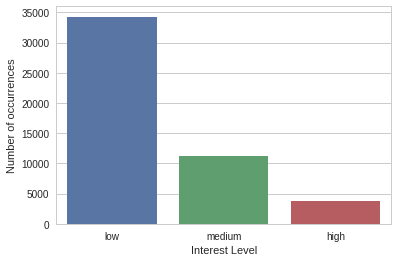

In [46]:
#Explore the training data - interest_level 
sns.countplot(train_data.interest_level, order=['low', 'medium', 'high']);
plt.xlabel('Interest Level');
plt.ylabel('Number of occurrences');

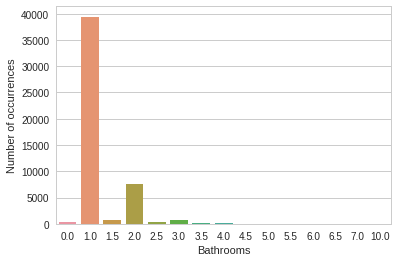

In [47]:
sns.countplot(train_data.bathrooms);
plt.xlabel('Bathrooms');
plt.ylabel('Number of occurrences');

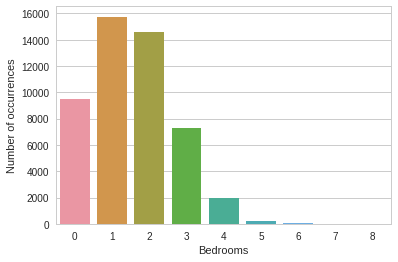

In [48]:
sns.countplot(train_data.bedrooms);
plt.xlabel('Bedrooms');
plt.ylabel('Number of occurrences');

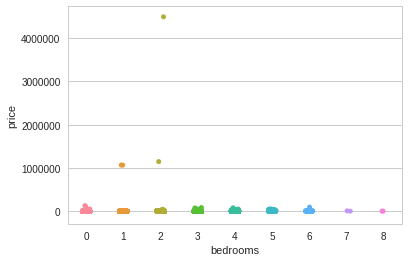

In [49]:
sns.stripplot(x="bedrooms", y="price", data=train_data, jitter=True);

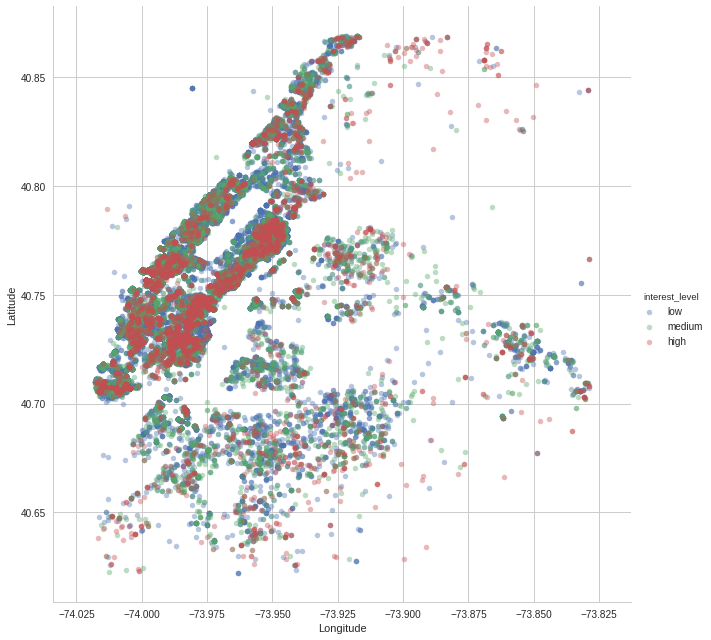

In [50]:
sns.lmplot(x="longitude", y="latitude", fit_reg=False, hue='interest_level',
           hue_order=['low', 'medium', 'high'], size=9, scatter_kws={'alpha':0.4,'s':30},
           data=train_data[(train_data.longitude>train_data.longitude.quantile(0.005))
                           &(train_data.longitude<train_data.longitude.quantile(0.995))
                           &(train_data.latitude>train_data.latitude.quantile(0.005))                           
                           &(train_data.latitude<train_data.latitude.quantile(0.995))]);
plt.xlabel('Longitude');
plt.ylabel('Latitude');

In [51]:
train_data["num_photos"]=train_data["photos"].apply(len)
train_data["num_features"]=train_data["features"].apply(len)
train_data["num_description_words"] = train_data["description"].apply(lambda x: len(x.split(" ")))

In [52]:
train_data["created"]=pd.to_datetime(train_data["created"])
train_data["created_month"]=train_data["created"].dt.month
train_data["created_day"]=train_data["created"].dt.day
train_data["created_hour"]=train_data["created"].dt.hour

In [53]:
train_data["Source"]='train'
test_data["Source"]='test'

In [54]:
data=pd.concat([train_data, test_data]) 

In [55]:
target_num_map={"high":0, "medium":1, "low":2}

In [56]:
features_to_use  = ["bathrooms", "bedrooms", "price",                               
                    "num_photos", "num_features", "num_description_words",                    
                    "created_month", "created_day", "created_hour"
                   ]

In [57]:
y=np.array(train_data["interest_level"].apply(lambda x: target_num_map[x]))

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_val,y_train, y_val =train_test_split( train_data[features_to_use], y, test_size=0.33, random_state=42)

In [59]:
from sklearn.ensemble import RandomForestClassifier as RFC
clf=RFC(n_estimators=1000, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [60]:
from sklearn.metrics import log_loss
y_val_pred = clf.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.65132633924502603

In [61]:
from sklearn.cluster import Birch
def cluster_latlon(n_clusters, data ):  
    #split the data between "around NYC" and "other locations" basically our first two clusters 
    data_c=data[(data.longitude>-74.05)&(data.longitude<-73.75)&(data.latitude>40.4)&(data.latitude<40.9)]
    data_e=data[~(data.longitude>-74.05)&(data.longitude<-73.75)&(data.latitude>40.4)&(data.latitude<40.9)]
    #put it in matrix form
    coords=data_c.as_matrix(columns=['latitude', "longitude"])
    
    brc = Birch(branching_factor=100, n_clusters=n_clusters, threshold=0.01,compute_labels=True, copy =True)

    brc.fit(coords)
    clusters=brc.predict(coords)
    data_c["cluster_"+str(n_clusters)]=clusters
    data_e["cluster_"+str(n_clusters)]=-1 #assign cluster label -1 for the non NYC listings 
    data=pd.concat([data_c,data_e])
    plt.scatter(data_c["longitude"], data_c["latitude"], c=data_c["cluster_"+str(n_clusters)], s=10, linewidth=0.1)
    plt.title(str(n_clusters)+" Neighbourhoods from clustering")
    plt.show()
    return data 

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


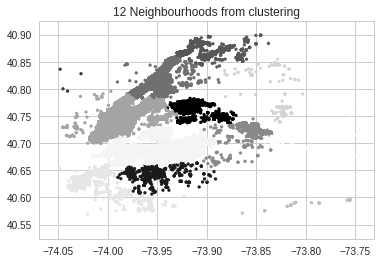

,Source,bathrooms,bedrooms,building_id,created,created_day,created_hour,created_month,description,display_address,...,listing_id,longitude,manager_id,num_description_words,num_features,num_photos,photos,price,street_address,cluster_12
10,train,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,24.0,7.0,6.0,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,...,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,95.0,0.0,5.0,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,1
10000,train,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,12.0,12.0,6.0,,Columbus Avenue,...,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,9.0,5.0,11.0,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,7
100004,train,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,17.0,3.0,4.0,"Top Top West Village location, beautiful Pre-w...",W 13 Street,...,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,94.0,4.0,8.0,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,5
100007,train,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,18.0,2.0,4.0,Building Amenities - Garage - Garden - fitness...,East 49th Street,...,6888711,-73.9677,1067e078446a7897d2da493d2f741316,80.0,2.0,3.0,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,5
100013,train,1.0,4,0,2016-04-28 01:32:41,28.0,1.0,4.0,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,...,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,68.0,1.0,3.0,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,7
100014,train,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,19.0,4.0,4.0,,West 18th Street,...,6894514,-74.0028,b209e2c4384a64cc307c26759ee0c651,9.0,0.0,5.0,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,5
100016,train,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,27.0,3.0,4.0,Stunning unit with a great location and lots o...,West 107th Street,...,6930771,-73.9660,01287194f20de51872e81f660def4784,87.0,8.0,10.0,[https://photos.renthop.com/2/6930771_7e3622b6...,3600,210 West 107th Street,7
100020,train,2.0,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,13.0,6.0,4.0,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,...,6867392,-73.9957,e6472c7237327dd3903b3d6f6a94515a,134.0,8.0,5.0,[https://photos.renthop.com/2/6867392_b18283f6...,5645,155 West 21st Street,5
100026,train,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,20.0,2.0,4.0,<p><a website_redacted,Hamilton Terrace,...,6898799,-73.9457,c1a6598437b7db560cde66e5a297a53f,4.0,4.0,5.0,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,7
100027,train,2.0,4,0,2016-04-02 02:58:15,2.0,2.0,4.0,This is a spacious four bedroom with every bed...,522 E 11th,...,6814332,-73.9808,23a01ea7717b38875f5b070282d1b9d2,166.0,2.0,9.0,[https://photos.renthop.com/2/6814332_e19a8552...,5800,522 E 11th,5


In [62]:
cluster_latlon(12, data)


In [64]:
from sklearn.metrics import log_loss


def compute_logloss(n_cluster,data):
    data_cluster=cluster_latlon(n_cluster,data)
    train=data_cluster[data_cluster["Source"]=="train"]

    target_num_map={"high":0, "medium":1, "low":2}
    y=np.array(train["interest_level"].apply(lambda x: target_num_map[x]))
    
    features = ["bathrooms", "bedrooms", "price", 
                                                        
                    "num_photos", "num_features", "num_description_words",                    
                    "created_month", "created_day", "created_hour", "cluster_"+str(n_cluster)
                   ]
    
    X_train, X_val,y_train, y_val =train_test_split( train[features], y, test_size=0.33, random_state=42)
    clf.fit(X_train, y_train)

    y_val_pred = clf.predict_proba(X_val)
    return log_loss(y_val, y_val_pred)

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


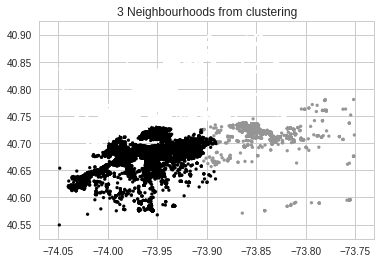

0.64810696669524437

In [65]:
compute_logloss(3, data)

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


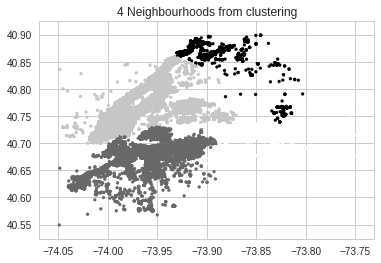

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


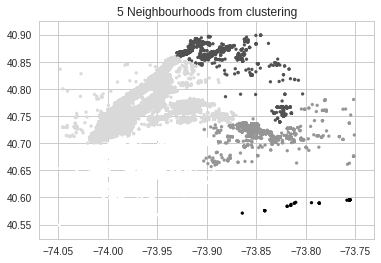

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


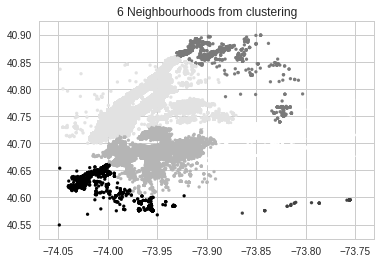

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


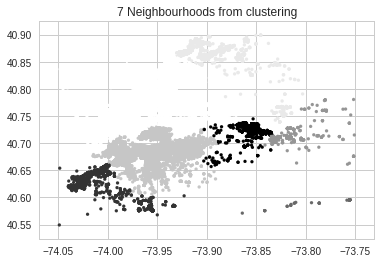

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


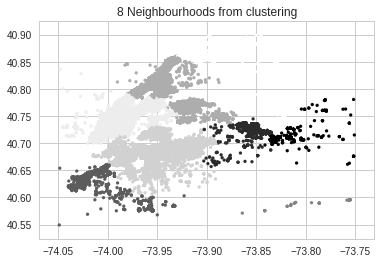

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


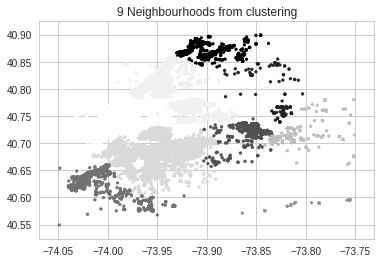

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


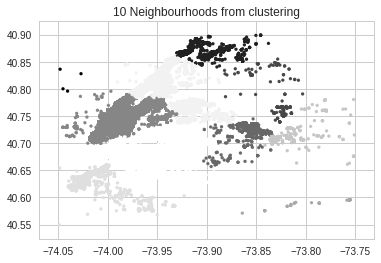

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


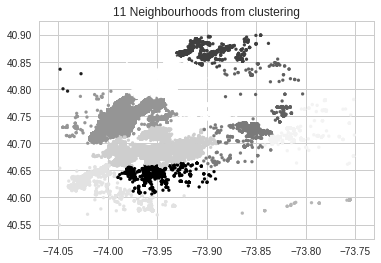

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


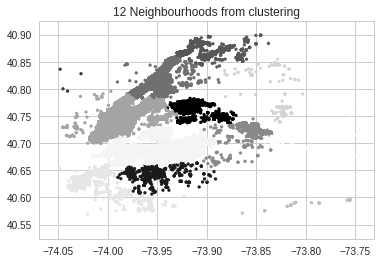

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


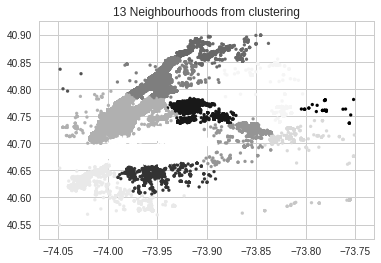

/opt/conda/bin/ipython:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/bin/ipython:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


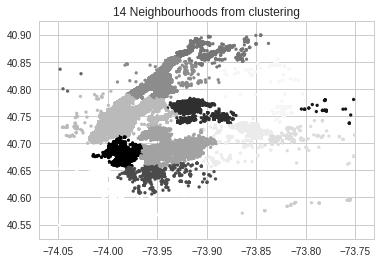

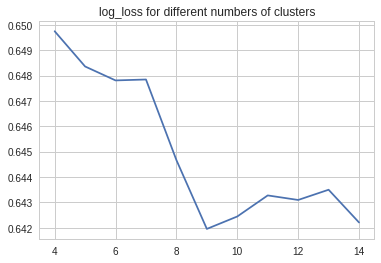

In [66]:
log_loss_cls={}
for n in range(4,15):
    log_loss_cls[n]=compute_logloss(n, data)
    
n_c = sorted(log_loss_cls.items()) 
x, y = zip(*n_c) 
plt.plot(x, y)
plt.title("log_loss for different numbers of clusters")
plt.show()

In [67]:
log_loss_cls

{4: 0.64974543153990605,
 5: 0.6483567173773811,
 6: 0.64780749472583132,
 7: 0.64784379211878673,
 8: 0.64466807307555574,
 9: 0.64195542421071938,
 10: 0.6424456319134495,
 11: 0.64327549891177616,
 12: 0.64309633550546652,
 13: 0.64349966764465094,
 14: 0.64220949636930291}